In [1]:
case='TRPC12N00'
year='2012'

In [2]:
# Parameters
case = "TRPC12N00"
year = "2012"


In [3]:
# General and file management
import numpy as np
import numpy.ma as ma
import xarray as xr
from netCDF4 import Dataset
import dask.array as da

#For the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.ticker as mticker

import cartopy
cartopy.config['pre_existing_data_dir'] = '/scratch/cnt0024/hmg2840/albert7a/DEV/git/cartopy_data'
import cartopy.crs as ccrs
import cmocean

import warnings
warnings.filterwarnings('ignore')

#Jupyter magics
%matplotlib inline

In [4]:
# Request ressource
import multiprocessing.popen_spawn_posix
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
c = Client(cluster)
c

Client Scheduler: tcp://127.0.0.1:44115 Dashboard: http://127.0.0.1:43910/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [5]:
# Open data and mask
ds=xr.open_mfdataset('/store/CT1/hmg2840/lbrodeau/TROPICO12/TROPICO12_NST-'+case+'-S/*/NST/'+case+'-CALEDO60_*'+year+'*gridT-2D.nc4',parallel=True,concat_dim='time_counter',combine='nested',chunks={'x':1000,'y':500})
dscoord=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/NST/1_coordinates_TROPICO12.nc')
dsmask=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/NST/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={'x','y'})


In [6]:
# Generic plot 
def plot_surf_tropico(ax, proj, var, cmap,vmin,vmax,label,title):
    ax.coastlines()
    ax.gridlines(draw_labels=True, crs=proj)
    cs = plt.pcolormesh(dscoord.nav_lon-cm, dscoord.nav_lat, var,transform=proj,cmap=cmap,
                    vmin=vmin,vmax=vmax)
    cbar = plt.colorbar(cs,orientation='vertical',shrink=0.5,label='deg C')
    ax.set_title(title)


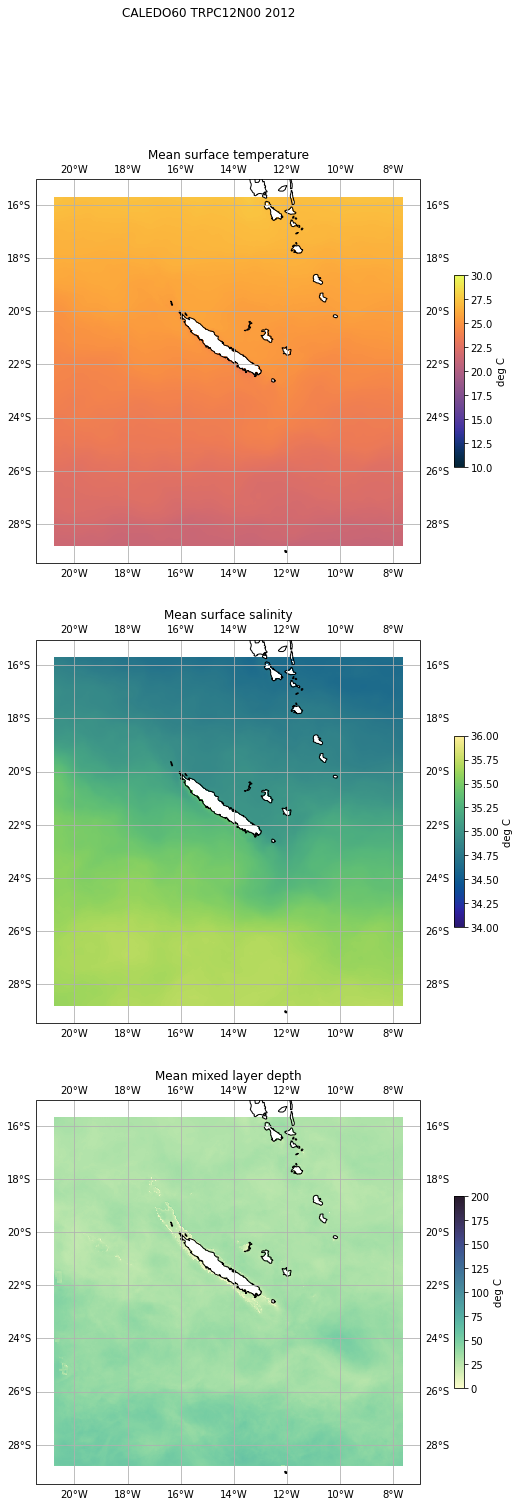

In [7]:
# Make plots of every surface mean fields
cm = 180
proj = ccrs.PlateCarree(central_longitude=cm)

fig = plt.figure(figsize=[12, 24])
plt.suptitle("CALEDO60 "+case+" "+year)

ax = fig.add_subplot(3, 1, 1, projection=proj)
tmean_surf=ds.tos.mean(dim='time_counter')
tmask_surf=dsmask.tmask[0,0]
tmeansurf_mask=ma.masked_where(tmask_surf==0.,tmean_surf)
plot_surf_tropico(ax, proj, tmeansurf_mask, cmocean.cm.thermal,10,30,'deg C','Mean surface temperature')

ax = fig.add_subplot(3, 1, 2, projection=proj)
smean_surf=ds.sos.mean(dim='time_counter')
smeansurf_mask=ma.masked_where(tmask_surf==0.,smean_surf)
plot_surf_tropico(ax, proj, smeansurf_mask, cmocean.cm.haline,34,36,'PSU','Mean surface salinity')

ax = fig.add_subplot(3, 1, 3, projection=proj)
mldmean=ds.mldr10_1.mean(dim='time_counter')
mldmean_mask=ma.masked_where(tmask_surf==0.,mldmean)
plot_surf_tropico(ax, proj, mldmean_mask, cmocean.cm.deep,0,200,'m','Mean mixed layer depth')

plt.savefig('plots/CALEDO60-'+case+'_maps_surface_fields_'+year+'.png', bbox_inches='tight')